# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Stratified K-Fold Cross Validation

In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [9]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.888783
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.808303
[3]	valid_0's multi_logloss: 0.735768
[4]	valid_0's multi_logloss: 0.674393
[5]	valid_0's multi_logloss: 0.621266
[6]	valid_0's multi_logloss: 0.579717
[7]	valid_0's multi_logloss: 0.540529
[8]	valid_0's multi_logloss: 0.508314
[9]	valid_0's multi_logloss: 0.481377
[10]	valid_0's multi_logloss: 0.451845
[11]	valid_0's multi_logloss: 0.426169
[12]	valid_0's multi_logloss: 0.402967
[13]	valid_0's multi_logloss: 0.382223
[14]	valid_0's multi_logloss: 0.363352
[15]	valid_0's multi_logloss: 0.346798
[16]	valid_0's multi_logloss: 0.332813
[17]	valid_0's multi_logloss: 0.319653
[18]	valid_0's multi_logloss: 0.307032
[19]	valid_0's multi_logloss: 0.295718
[20]	valid_0's multi_logloss: 0.285881
[21]	valid_0's multi_logloss: 0.276321
[22]	valid_0's multi_logloss: 0.267506
[23]	valid_0's multi_logloss: 0.259526
[24]	valid_0's multi_loglo

[98]	valid_0's multi_logloss: 0.165769
[99]	valid_0's multi_logloss: 0.165733
[100]	valid_0's multi_logloss: 0.165622
[101]	valid_0's multi_logloss: 0.165559
[102]	valid_0's multi_logloss: 0.165496
[103]	valid_0's multi_logloss: 0.165434
[104]	valid_0's multi_logloss: 0.165403
[105]	valid_0's multi_logloss: 0.165334
[106]	valid_0's multi_logloss: 0.165257
[107]	valid_0's multi_logloss: 0.165189
[108]	valid_0's multi_logloss: 0.16508
[109]	valid_0's multi_logloss: 0.164988
[110]	valid_0's multi_logloss: 0.164952
[111]	valid_0's multi_logloss: 0.164895
[112]	valid_0's multi_logloss: 0.164917
[113]	valid_0's multi_logloss: 0.16486
[114]	valid_0's multi_logloss: 0.164812
[115]	valid_0's multi_logloss: 0.164754
[116]	valid_0's multi_logloss: 0.164707
[117]	valid_0's multi_logloss: 0.164655
[118]	valid_0's multi_logloss: 0.164612
[119]	valid_0's multi_logloss: 0.164579
[120]	valid_0's multi_logloss: 0.1645
[121]	valid_0's multi_logloss: 0.164443
[122]	valid_0's multi_logloss: 0.164383
[123]	

[34]	valid_0's multi_logloss: 0.210625
[35]	valid_0's multi_logloss: 0.207675
[36]	valid_0's multi_logloss: 0.205147
[37]	valid_0's multi_logloss: 0.20264
[38]	valid_0's multi_logloss: 0.200329
[39]	valid_0's multi_logloss: 0.198171
[40]	valid_0's multi_logloss: 0.196188
[41]	valid_0's multi_logloss: 0.194275
[42]	valid_0's multi_logloss: 0.192641
[43]	valid_0's multi_logloss: 0.191064
[44]	valid_0's multi_logloss: 0.189526
[45]	valid_0's multi_logloss: 0.188352
[46]	valid_0's multi_logloss: 0.187087
[47]	valid_0's multi_logloss: 0.18584
[48]	valid_0's multi_logloss: 0.184776
[49]	valid_0's multi_logloss: 0.183723
[50]	valid_0's multi_logloss: 0.182657
[51]	valid_0's multi_logloss: 0.181664
[52]	valid_0's multi_logloss: 0.180843
[53]	valid_0's multi_logloss: 0.180019
[54]	valid_0's multi_logloss: 0.179386
[55]	valid_0's multi_logloss: 0.178744
[56]	valid_0's multi_logloss: 0.178092
[57]	valid_0's multi_logloss: 0.177489
[58]	valid_0's multi_logloss: 0.176858
[59]	valid_0's multi_loglos

[136]	valid_0's multi_logloss: 0.164964
[137]	valid_0's multi_logloss: 0.164927
[138]	valid_0's multi_logloss: 0.164865
[139]	valid_0's multi_logloss: 0.164844
[140]	valid_0's multi_logloss: 0.164841
[141]	valid_0's multi_logloss: 0.164825
[142]	valid_0's multi_logloss: 0.164826
[143]	valid_0's multi_logloss: 0.164768
[144]	valid_0's multi_logloss: 0.164733
[145]	valid_0's multi_logloss: 0.164709
[146]	valid_0's multi_logloss: 0.164699
[147]	valid_0's multi_logloss: 0.164654
[148]	valid_0's multi_logloss: 0.164605
[149]	valid_0's multi_logloss: 0.164593
[150]	valid_0's multi_logloss: 0.164566
[151]	valid_0's multi_logloss: 0.164526
[152]	valid_0's multi_logloss: 0.164456
[153]	valid_0's multi_logloss: 0.16446
[154]	valid_0's multi_logloss: 0.164389
[155]	valid_0's multi_logloss: 0.164354
[156]	valid_0's multi_logloss: 0.164278
[157]	valid_0's multi_logloss: 0.164207
[158]	valid_0's multi_logloss: 0.164227
[159]	valid_0's multi_logloss: 0.164233
[160]	valid_0's multi_logloss: 0.164213
[

[113]	valid_0's multi_logloss: 0.164593
[114]	valid_0's multi_logloss: 0.164935
[115]	valid_0's multi_logloss: 0.164825
[116]	valid_0's multi_logloss: 0.164531
[117]	valid_0's multi_logloss: 0.164465
[118]	valid_0's multi_logloss: 0.164425
[119]	valid_0's multi_logloss: 0.164327
[120]	valid_0's multi_logloss: 0.16428
[121]	valid_0's multi_logloss: 0.164234
[122]	valid_0's multi_logloss: 0.164206
[123]	valid_0's multi_logloss: 0.164153
[124]	valid_0's multi_logloss: 0.164138
[125]	valid_0's multi_logloss: 0.16408
[126]	valid_0's multi_logloss: 0.164009
[127]	valid_0's multi_logloss: 0.164
[128]	valid_0's multi_logloss: 0.163976
[129]	valid_0's multi_logloss: 0.163996
[130]	valid_0's multi_logloss: 0.163968
[131]	valid_0's multi_logloss: 0.163916
[132]	valid_0's multi_logloss: 0.163788
[133]	valid_0's multi_logloss: 0.163761
[134]	valid_0's multi_logloss: 0.163759
[135]	valid_0's multi_logloss: 0.163752
[136]	valid_0's multi_logloss: 0.163708
[137]	valid_0's multi_logloss: 0.163663
[138]

In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.1306%


In [11]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

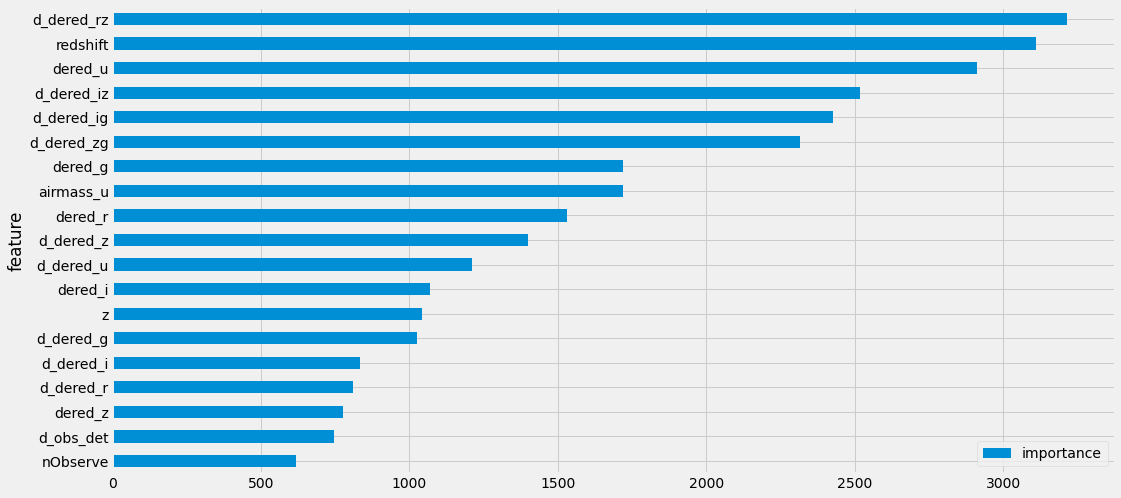

In [13]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [14]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    41170
0    29971
1     8859
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)